# 1. Camera Calibration

This script is an extension of the previous. In this one, it's added non-linear refinement of the homography matrix using LM\
For this implementation we will use the Zhang's calibration method.

**Import the libraries**

In [38]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
#for LM method
from scipy.optimize import curve_fit
#%matplotlib widget

## Zhang's Method
Comparing to the DLT method, the Zhang method only calculate the intrinsic parameters. We instead only need to find 5 parameters.

### Implementation:

## 1. Import the 2D and 3D coordinates
This is example is not completely right since we need more than 3 diferent views to estimate H using Zhang's method.

In [39]:

#worldcoo = np.array([ (0,0,0), (0,28,0), (56,0,0), (56,28,0), (56,84,0), (84,84,0), (112,56,0),
#             (112,84,0), (84,56,0), (84,112,0), (0,28,28), (0,28,56), (0,56,28), (0,56,56), 
#             (0,56,84), (0,56,112), (0,112,0), (0,112,28), (0,112,56), (0,112,84), (0,112,112) 
#           ])

#imagecoo = np.array([ (1549, 1599), (1547, 1763), (1797, 1625), (1793, 1807), (1785, 2156), (1918, 2196),
#            (2069, 2051), (2061, 2233), (1928, 2015), (1915, 2366), (1413, 1781), (1280, 1807),
#             (1415, 1958), (1283, 1981), (1139, 2013), (990, 2041), (1541, 2251), (1420, 2287),
#             (1292, 2320), (1149, 2356), (1005, 2401)
#           ])
#print("World coordinate have : "+str(worldcoo.shape)+ " dimensions\n")
#print("Image coordinate have : "+str(imagecoo.shape)+ " dimensions\n")

We need to **remove the Z coordinate** from the World coordinate since we are using the chessboard calibration

In [40]:
#worldcoo = worldcoo[:,:2]

## 2. Normalize matrix
Normalization of input data. To improve numerical stability of the calculations, it is recommended to normalize both 2D point sets X and x before performing the homography estimation. Burger[pag.14]

In [41]:
# Normalizing a given 2D point set is accomplished by shifting and scaling all points such that the centroid od the 
# transformed set is aligned with the origin and its diameter has a predefined size.
# There are various methods in the literature to calculate the normalization. In this case, the method used is 
# applied scaling non-unformly in x- and y- direction such that the variances along both axis get normalized. Burger[appendix B, pag 46]
def matrix_normalization(data):
    """
       Args:
          data: Nx2 stack of data points
        Returns:
          The normalization matrix
    """
    if data.ndim != 2 or data.shape[-1] != 2:
        raise ValueError('Dataset must be a collection of 2D points')

    x, y = data[:, 0], data[:, 1]

    N = data.shape[0]

    x_mean, y_mean = x.mean(), y.mean()
    x_var, y_var = x.var(), y.var()
    
    # Form rescaling matrix so that data points will lie
    # sqrt(2) from the origin on average.
    s_x, s_y = np.sqrt(2. / x_var), np.sqrt(2. / y_var)
    
    norm_matrix = np.array([[s_x,  0., -s_x * x_mean],
                            [ 0., s_y, -s_y * y_mean],
                            [ 0.,  0.,            1.]])

    return norm_matrix


## Obtain the Corner information of images

### Finding the corner of the checkerboard
+ With 9 images, each one with 48 image points
+ The checkerboard has 25mm between corners

In [42]:
# number of images
n_imgs = 9
# pattern size
#patternsize= (10,8)
patternsize= (6,8)
#distance between squares(in mm)
dist = 25

# specified number of iterations are completed.
criteria = (cv2.TERM_CRITERIA_EPS +
            cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Vector for 3D points
threedpoints = []
 
# Vector for 2D points
twodpoints = []

#3D points real world coordinates( static -> chessboard)
# create a matrix of zeros for 48 points , each with 3 coordinates
world_coo = np.zeros((1, patternsize[0]* patternsize[1],3), np.float32)
world_coo[:, :, :2] = np.mgrid[0:patternsize[0], 0:patternsize[1]].T.reshape(-1, 2)
# Transform coordinates in mm
world_coo = world_coo*dist

#prev_img_shape = None

for i in range(n_imgs):
    
    #Import the image
    #img = cv2.imread(("Research/BinoCameraCalibrate-master/BinoCameraCalibrate/Calibration_Image_Camera/Image_l"+str(i+1)+".jpg"))
    name = ("Chessboard_real_"+ str(i+1)+".jpeg")
    img = cv2.imread(name)
    # convert it to gray scale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    
    retval, corners= cv2.findChessboardCorners(gray,patternsize,cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK +cv2.CALIB_CB_NORMALIZE_IMAGE)
    
    if(retval == True):
        threedpoints.append(world_coo)

        # Refining pixel coordinates or given 2d points.
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria).reshape(patternsize[0]*patternsize[1],2)

        twodpoints.append(corners2)
        # Draw and display the corners
        image = cv2.drawChessboardCorners(img,patternsize,corners2,retval)
        plt.imshow(image)
        #plt.show()

# image coordinates and world coordinates for the diferent images( the world coordinates are always the same)
imagecoo = np.asarray(twodpoints)
worldcoo = np.asarray(threedpoints) 

# 3. Homography estimation with the DLT

## 3.1 Solving homogeneous systems of linear equations: **SVD**
**goal : find the homography matrix (H)** 
- Normalization matrix
- Apply the matrix to the coordinates
- Homogenous coordinates transformation
- Having a system M*h = , we apply SVD(M). 
- Denormalize the matrix

In [43]:
# transform coordinates to euclidean
def to_euclidean(homogeneous_coordinate):
    euclidean = homogeneous_coordinate[:,:]/(homogeneous_coordinate[:,-1][:,np.newaxis])

    return euclidean[:,:-1]

In [44]:
# transform coordinates to homogenous
def to_homogeneous(euclideancoo):

    if euclideancoo.ndim != 2 or euclideancoo.shape[-1] != 2:
        raise ValueError('Stacked vectors must be 2D inhomogeneous')
    
    M,N = euclideancoo.shape
    homogeneous = np.hstack(((euclideancoo),np.ones((M,1))))
    
    return homogeneous
    

In [45]:
def homography_matrix(worldcoo,imagecoo):
    # get the shape of the matrix
    worldm, worldn = worldcoo.shape
    imagem, imagen = imagecoo.shape

    homo_world = to_homogeneous(worldcoo) 
    homo_image = to_homogeneous(imagecoo)

    # world coordinate normalization
    X_matrix_norm = matrix_normalization(worldcoo)
    # image coordinate normalization
    x_matrix_norm = matrix_normalization(imagecoo)
    
    # Normalize the coordinates
    world_norm = np.dot(homo_world,X_matrix_norm.T)
    image_norm = np.dot(homo_image,x_matrix_norm.T)

    #2D DLT
    X, Y, x, y = world_norm[:,0],world_norm[:,1], image_norm[:,0], image_norm[:,1]

    A = np.zeros((worldm * 2, 9))

    M_x = np.zeros((worldm, 9))
    M_x[:, 0] = -X
    M_x[:, 1] = -Y
    M_x[:, 2] = -1.
    M_x[:, 6] =  x * X
    M_x[:, 7] =  x * Y
    M_x[:, 8] =  x

    M_y = np.zeros((worldm, 9))
    M_y[:, 3] = -X
    M_y[:, 4] = -Y
    M_y[:, 5] = -1.
    M_y[:, 6] =  y * X
    M_y[:, 7] =  y * Y
    M_y[:, 8] =  y

    # Note that all x-constraints precede all y-constraints for convenience of 
    # representation.
    A[:worldm] = M_x
    A[worldm:] = M_y

    U, S, V = np.linalg.svd(A)
    # get the min Singular value
    idx = np.argmin(S)
    H = V[idx].reshape((3,3))
    
    # Denormalize the coordinates
    H = np.dot(np.dot(np.linalg.inv(x_matrix_norm), H), X_matrix_norm)

    return H


## 3.1.1 Homography matrix 

In [46]:
# empty array to store the homographies
H = np.zeros((n_imgs,3,3))
# empty array to store the normalized homographies
H_norm= np.zeros((n_imgs,3,3))
# world coordinates
wo = worldcoo[0][:].reshape(patternsize[0]*patternsize[1],3)
# remove the Z coordinate
wo = wo[:,:2]

for i in range(n_imgs):
    im = imagecoo[i][:][:].reshape(patternsize[0]*patternsize[1],2)
    # homography matrix
    H[i,:] = homography_matrix(wo,im)
    # normalized homography matrix
    H_norm[i,:] = H[i,:]/H[i,-1,-1]
#print(H_norm)    

## 3.1.2 Homagraphy matrix refinement
Non-linear refiment of the homography matrix using **Levenberg-Marquardt**

### Aux functions
**a) jacobian refine**

In [47]:
def jac_refine(xdata, *params):
    """Jacobian function for Levenberg-Marquardt refinement.
    """
    h11, h12, h13, h21, h22, h23, h31, h32, h33 = params

    N = xdata.shape[0] // 2

    X = xdata[:N]
    Y = xdata[N:]

    J = np.zeros((N * 2, 9))
    J_x = J[:N]
    J_y = J[N:]

    s_x = h11 * X + h12 * Y + h13
    s_y = h21 * X + h22 * Y + h23
    w   = h31 * X + h32 * Y + h33
    w_sq = w**2

    J_x[:, 0] = X / w
    J_x[:, 1] = Y / w
    J_x[:, 2] = 1. / w
    J_x[:, 6] = (-s_x * X) / w_sq
    J_x[:, 7] = (-s_x * Y) / w_sq
    J_x[:, 8] = -s_x / w_sq

    J_y[:, 3] = X / w
    J_y[:, 4] = Y / w
    J_y[:, 5] = 1. / w
    J_y[:, 6] = (-s_y * X) / w_sq
    J_y[:, 7] = (-s_y * Y) / w_sq
    J_y[:, 8] = -s_y / w_sq

    J[:N] = J_x
    J[N:] = J_y

    return J


**b) Value function LM refinement**

In [48]:
def f_refine(xdata, *params):
    """Value function for Levenberg-Marquardt refinement.
    """
    h11, h12, h13, h21, h22, h23, h31, h32, h33 = params

    N = xdata.shape[0] // 2

    X = xdata[:N]
    Y = xdata[N:]

    x = (h11 * X + h12 * Y + h13) / (h31 * X + h32 * Y + h33)
    y = (h21 * X + h22 * Y + h23) / (h31 * X + h32 * Y + h33)

    result = np.zeros_like(xdata)
    result[:N] = x
    result[N:] = y

    return result

**c) Nonlinear LS to refine linear homography estimates**

In [49]:
def refine_homography(H,worldcoo,imagecoo):
    """
    Performs nonlinear LS to refine linear homography estimates.
    
    Args:
        H : 3x3 homography matrix
        worldcoo : Nx2 world coordinates
        imagecoo : Nx2 image coordinates
    Returns:
        Refined 3x3 homography
    """
    X,Y,x,y = worldcoo[:,0],worldcoo[:,1],imagecoo[:,0],imagecoo[:,1]
    
    N = X.shape[0]
    
    h0 = H.ravel()

    xdata = np.zeros(N * 2)
    xdata[:N] = X
    xdata[N:] = Y

    ydata = np.zeros(N * 2)
    ydata[:N] = x
    ydata[N:] = y

    # Use Levenberg-Marquardt to refine the linear homography estimate
    popt, pcov = curve_fit(f_refine, xdata, ydata, p0=h0, jac=jac_refine)
    h_refined = popt
    
    # Normalize and reconstitute homography
    h_refined /= h_refined[-1]
    H_refined = h_refined.reshape((3,3))

    return H_refined

## 3.1.3 Homography matrix

In [50]:
# empty array to store the homographies
H_refined = np.zeros((n_imgs,3,3))
# temporary array 
H_temp = np.array((3,3))
# world coordinates
wo = worldcoo[0][:].reshape(patternsize[0]*patternsize[1],3)
# remove the Z coordinate
wo = wo[:,:2]

for i in range(n_imgs):
    im = imagecoo[i][:][:].reshape(patternsize[0]*patternsize[1],2)
    H_temp = homography_matrix(wo,im)
    H_refined[i,:] = refine_homography(H_temp,wo,im)


## 4. Determining the intrinsic camera parameters
Use the computed homographies to calculate the intrisic matrix \
Since H has **8DoF, it's needed >= 4 points to estimate the homography**

### 4.1 Generate $V_{pq}$

In [51]:
def generate_v(H_stack, i, j):
    """Generate intrinsic orthogonality constraints. See Zhang pg. 6 for
       details.
    """ 
    M = H_stack.shape[0]

    v_ij = np.zeros((M, 6))
    v_ij[:, 0] = H_stack[:, 0, i] * H_stack[:, 0, j]
    v_ij[:, 1] = H_stack[:, 0, i] * H_stack[:, 1, j] + H_stack[:, 1, i] * H_stack[:, 0, j]
    v_ij[:, 2] = H_stack[:, 1, i] * H_stack[:, 1, j]
    v_ij[:, 3] = H_stack[:, 2, i] * H_stack[:, 0, j] + H_stack[:, 0, i] * H_stack[:, 2, j]
    v_ij[:, 4] = H_stack[:, 2, i] * H_stack[:, 1, j] + H_stack[:, 1, i] * H_stack[:, 2, j]
    v_ij[:, 5] = H_stack[:, 2, i] * H_stack[:, 2, j]

    return v_ij


### 4.2 Compute the intrisic Matrix.
We need >= 3 homographies for a full 5-parameter intrinsic matrix.


In [52]:
def intrisicmatrix(H):
    M = len(H)

    V01 = generate_v(H,0,1)
    V00 = generate_v(H,0,0)
    V11 = generate_v(H,1,1)

    # vq(H) is a 6 dimensional row vector obtained from the estimated Homography H
    V = np.zeros((2*M,6))

    V[:M] = V01
    V[M:] = V00-V11

    # Use SVD to solve the homogeneous system Vb = 0( In this case we have a overdetermined system)
    U, S, Vh = np.linalg.svd(V)
    idx = np.argmin(S)
    b = Vh[idx]


    # camera intrinsics( Zhang creates a new matrix which is symmetric and composed of only 6 distinct quantities)
    B0, B1, B2, B3, B4, B5 = b

    # B = A^(-T)*A^(-1)
    B = np.array([[B0,B1,B3],
                  [B1,B2,B4],
                  [B3,B4,B5]]);
    
    print(B)

    w = (B0*B2*B5) - ((B1**2)*(B5))-((B0)*(B4**2))+(2*B1*B3*B4)-((B2)*(B3**2))
    d = B0*B2 - B1**2

    v0 = (B[0,1] * B[0,2] - B[0,0] * B[1,2]) / (B[0,0] * B[1,1] - B[0,1]**2)
    lambda_ = B[2,2] - (B[0,2]**2 + v0 * (B[0,1] * B[0,2] - B[0,0] * B[1,2])) / B[0,0]
    print(lambda_)
    alpha = np.sqrt(lambda_ / B[0,0])
    beta = np.sqrt(lambda_ * B[0,0] / (B[0,0] * B[1,1] - B[0,1]**2))
    gamma = -1 * (B[0,1] * alpha * alpha * beta )/ lambda_
    u0 = (gamma * v0 / beta) - (B[0,2] * alpha * alpha / lambda_)


    # Reconstitute intrinsic matrix
    K = np.array([[alpha, gamma, u0],
                  [   0,  beta, v0],
                  [   0,    0, 1]])
    return K

In [53]:
K_refined = intrisicmatrix(H_refined)
print(K_refined)

[[-9.94076307e-07  3.39775215e-09  5.00794498e-04]
 [ 3.39775215e-09 -9.90758043e-07  3.67107740e-04]
 [ 5.00794498e-04  3.67107740e-04 -9.99999807e-01]]
-0.6104119014214286
[[783.6130049    2.68288596 505.05112802]
 [  0.         784.92875339 372.26422834]
 [  0.           0.           1.        ]]


In [54]:
K = intrisicmatrix(H)
print(K)

[[-1.00490630e-06  3.40566969e-09  5.04300432e-04]
 [ 3.40566969e-09 -1.00163530e-06  3.71244620e-04]
 [ 5.04300432e-04  3.71244620e-04 -9.99999804e-01]]
-0.6080535685949602
[[777.87199322   2.64055711 503.10016721]
 [  0.         779.14557997 372.34910923]
 [  0.           0.           1.        ]]


## 5. Recover the extrinsic parameters
After retrieving the intrinsic matrix, we use both the intrinsic and extrinsic matrix to calculate the corresponding extrinsic matrix( Burger, pag 19)

In [55]:
def extract_extrinsics(H,K):
    # obtain the column vectores from the homography matrix
    h0,h1,h2 = H[:,0],H[:,1],H[:,2]
    
    K_inv = np.linalg.inv(K)
    
    #norm the term
    lambda_ = 1. / np.linalg.norm(np.dot(K_inv, h0))
    
    r0 = (lambda_ * np.dot(K_inv,h0))
    r1 = (lambda_ * np.dot(K_inv,h1))
    t =  (lambda_ * np.dot(K_inv,h2)).reshape(3,1)

    # since R must be orthogonal
    r2 = np.cross(r0,r1)
    
    # rotation matrix reconstrution
    R = np.vstack((r0, r1, r2)).T
    
    # reorthogonalize the rotation matrix( Zhang, pag 18, Append C)
    #(The sense of "best" rotation matrix R is in the sense of the smallest Frobenius norm of the difference R-Q)
    U,S,Vt = np.linalg.svd(R)
    R_ortho = np.dot(U,Vt)
    extrinsics = np.hstack((R_ortho, t))
    
    return extrinsics

### 5.2 Compute the extrinsics based on the intrisincs already calculated

In [56]:
# list to store the extrinsic matrixes
extrinsic_matrices = []


# Homographies using the original intrinsic matrix
for h, Homograph in enumerate(H):
    E = extract_extrinsics(Homograph,K)
    extrinsic_matrices.append(E)
    
    # Projection matrix
    P = np.dot(K,E)
    
    # homogeneous world coordinates
    homo_world = np.append(worldcoo[0][:].reshape(patternsize[0]*patternsize[1],3),np.ones((patternsize[0]*patternsize[1],1)),axis = 1) 
    temp_var = np.dot(homo_world,P.T)
    # to euclidean coordinates
    actual_coo = to_euclidean(temp_var)
    predicted_coo = imagecoo[h]
    
    # least squares error
    ls_error = np.sum(np.abs(actual_coo-predicted_coo)**2)
    
print(ls_error)    
# Homographies using the refined intrinsic matrix    
for h, Homograph in enumerate(H_refined):
    E = extract_extrinsics(Homograph,K_refined)
    extrinsic_matrices.append(E)
    
    # Projection matrix
    P = np.dot(K_refined,E)
    # homogeneous world coordinates
    homo_world = np.append(worldcoo[0][:].reshape(patternsize[0]*patternsize[1],3),np.ones((patternsize[0]*patternsize[1],1)),axis = 1) 
    temp_var = np.dot(homo_world,P.T)
    # to euclidean coordinates
    actual_coo_LM = to_euclidean(temp_var)
    predicted_coo = imagecoo[h]
    
    # least squares error
    ls_error = np.sum(np.abs(actual_coo_LM-predicted_coo)**2)


print
print(ls_error)



242.44313945776645
193.59290124948905


# Visualization

In [57]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as p3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import numpy as np
from matplotlib import rc
from matplotlib.ticker import MultipleLocator

In [76]:
# From https://dawes.wordpress.com/2014/06/27/publication-ready-3d-figures-from-matplotlib/
rc('font',size=10)
rc('font',family='serif')
rc('axes',labelsize=10)
rc('lines', markersize=5)
rc('lines', markeredgewidth=10)

def make_axis_publishable(ax, major_x, major_y, major_z):
    # [t.set_va('center') for t in ax.get_yticklabels()]
    # [t.set_ha('left') for t in ax.get_yticklabels()]
    # [t.set_va('center') for t in ax.get_xticklabels()]
    # [t.set_ha('right') for t in ax.get_xticklabels()]
    # [t.set_va('center') for t in ax.get_zticklabels()]
    # [t.set_ha('left') for t in ax.get_zticklabels()]

    ax.grid(False)
    ax.xaxis.pane.set_edgecolor('black')
    ax.yaxis.pane.set_edgecolor('black')
    ax.zaxis.pane.set_edgecolor('black')
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.xaxis._axinfo['tick']['inward_factor'] = 0
    ax.xaxis._axinfo['tick']['outward_factor'] = 0.7
    ax.yaxis._axinfo['tick']['inward_factor'] = 0
    ax.yaxis._axinfo['tick']['outward_factor'] = 0.4
    ax.zaxis._axinfo['tick']['inward_factor'] = 0
    ax.zaxis._axinfo['tick']['outward_factor'] = 0.4
    ax.zaxis._axinfo['tick']['outward_factor'] = 0.4

    ax.xaxis.set_major_locator(MultipleLocator(major_x))
    ax.yaxis.set_major_locator(MultipleLocator(major_y))
    ax.zaxis.set_major_locator(MultipleLocator(major_z))


def visualize_camera_frame(model, extrinsics):
    N = model.shape[0]
    A_3d = np.hstack((model, np.zeros((N,1))))
    model = np.atleast_2d(A_3d)
    N = model.shape[0]
    model = np.hstack((model, np.ones((N,1))))


    fig =plt.figure()

    ax = fig.add_subplot(1,1,1, projection='3d')

    make_axis_publishable(ax, 10, 10, 10)

    ax.set_title('Camera-Centric Extrinsics')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(-100,100)
    ax.set_ylim(-100,100)
    ax.set_zlim(-20,40)

    # From StackOverflow: https://stackoverflow.com/questions/39408794/python-3d-pyramid
    v = np.array([[-0.5, -0.5, 1], [0.5, -0.5, 1], [0.5, 0.5, 1],  [-0.5, 0.5, 1], [0, 0, 0]])

    verts = [ [v[0],v[1],v[4]], [v[0],v[3],v[4]],
     [v[2],v[1],v[4]], [v[2],v[3],v[4]], [v[0],v[1],v[2],v[3]]]

    ax.add_collection3d(Poly3DCollection(verts, 
     facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))

    for E in extrinsics:
      model_ = np.dot(model, E.T)

      xs = model_[:,0]
      ys = model_[:,1]
      zs = model_[:,2]

      ax.plot_trisurf(xs, ys, zs)

    ax.invert_xaxis()

    plt.show()


def visualize_world_frame(model, extrinsics):
    
    N = model.shape[0]
    A_3d = np.hstack((model, np.zeros((N,1))))
    model = np.atleast_2d(A_3d)
    N = model.shape[0]
    model = np.hstack((model, np.ones((N,1))))


    fig =plt.figure()

    ax = fig.add_subplot(1,1,1, projection='3d')

    make_axis_publishable(ax, 3, 3, 10)

    ax.set_title('World-Centric Extrinsics')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(-100,100)
    ax.set_ylim(-100,100)
    ax.set_zlim(-20,40)

    # From StackOverflow: https://stackoverflow.com/questions/39408794/python-3d-pyramid
    v = np.array([[-0.5, -0.5, 1], [0.5, -0.5, 1], [0.5, 0.5, 1],  [-0.5, 0.5, 1], [0, 0, 0]])

    xs = model[:,0]
    ys = model[:,1]
    zs = model[:,2]

    ax.plot_trisurf(xs, ys, zs)

    A = np.atleast_2d(v)

    N = A.shape[0]
    v = np.hstack((A, np.ones((N,1))))

    for E in extrinsics:
        E = np.vstack((E, np.array([0.,0.,0.,1.])))
        E_inv = np.linalg.inv(E)
        E_inv = E_inv[:3]

        v_new = np.dot(v, E_inv.T)
 
        verts = [ [v_new[0],v_new[1],v_new[4]], [v_new[0],v_new[3],v_new[4]],
            [v_new[2],v_new[1],v_new[4]], [v_new[2],v_new[3],v_new[4]], [v_new[0],v_new[1],v_new[2],v_new[3]]]

        ax.add_collection3d(Poly3DCollection(verts, facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))

    ax.invert_xaxis()

    plt.show()

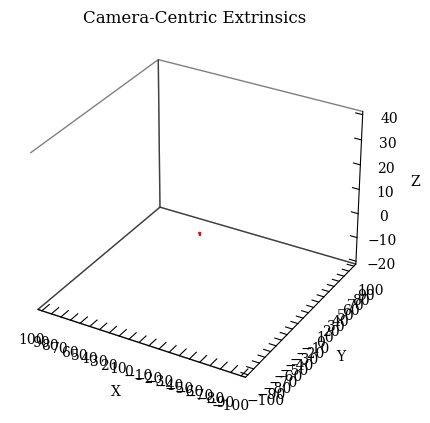

In [78]:
#print(extrinsic_matrices)
visualize_camera_frame(wo, extrinsic_matrices)